# Fuzzy ARTMAP utilizando a função VAT

Aqui, embaralharemos os dados e avaliaremos o modelo usando a métrica ARI.

## Importando bibliotecas

In [ ]:
import numpy as np
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score
from pyclustertend import vat
from artlib import FuzzyART
import pandas as pd

## Baixando base de dados

In [ ]:
transform = transforms.ToTensor()
full_dataset = datasets.USPS(root='./data', train=True, download=True, transform=transform)

X_list = []
y_list = []

for img, label in full_dataset:
    X_list.append(img.numpy().squeeze())  # shape (16,16)
    y_list.append(label)

X = np.array(X_list)  # (7291, 16, 16)
y = np.array(y_list)  # (7291,)
print("X:", X.shape, " y:", y.shape)

X: (7291, 16, 16)  y: (7291,)


### Achatando e normalização dos dados

In [ ]:
nsamples, h, w = X.shape
X_flat = X.reshape((nsamples, h * w))  # (7291, 256)

scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

### Dividindo entre treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_flat_scaled, y, test_size=0.4, random_state=42, stratify=y
)
print("Treino:", X_train.shape, "Teste:", X_test.shape)

Treino: (4374, 256) Teste: (2917, 256)


## Aplicando o VAT

Matriz ODM (ordered dissimilarity): (2000, 2000)


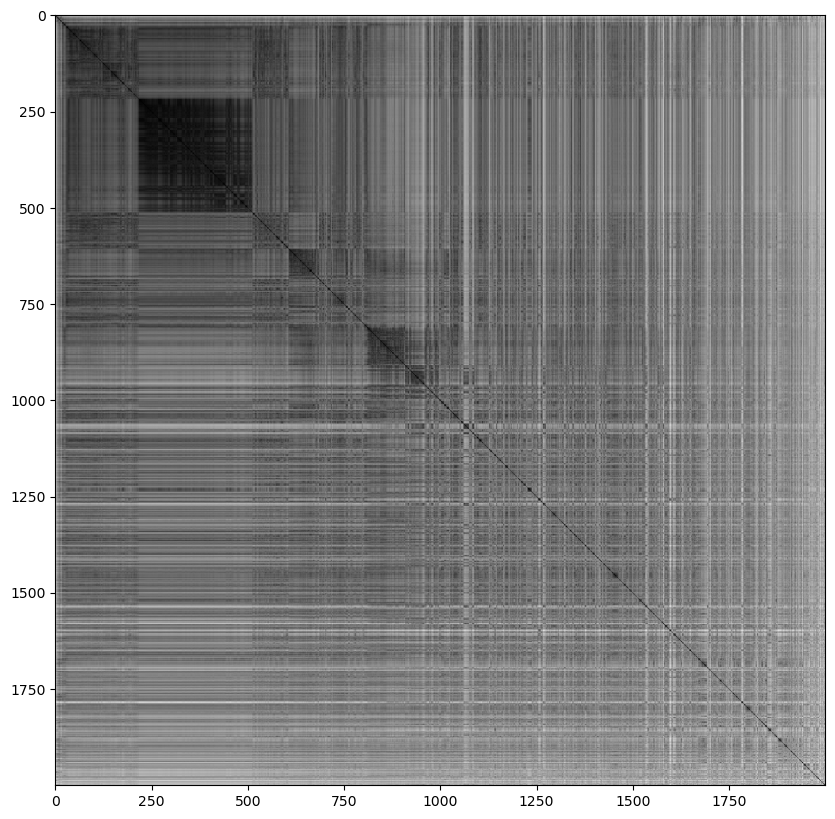

In [ ]:
X_sample = resample(X_train, n_samples=2000, random_state=42)

ODM = vat(X_sample, return_odm=True)
print("Matriz ODM (ordered dissimilarity):", ODM.shape)

## Treinando o modelo

In [ ]:
alphas = [1e-6, 1e-3, 1e-2, 1e-1, 1.0, 10.0] 
rhos   = [0.1, 0.3, 0.5, 0.7, 0.9]
betas  = [1.0, 0.5, 0.1]

results = []

for alpha in alphas:
    for rho in rhos:
        for beta in betas:

            model = FuzzyART(rho=rho, alpha=alpha, beta=beta)
            
            lower_bound, upper_bound = model.find_data_bounds(X)
            model.set_data_bounds(lower_bound, upper_bound)

            # Preparar os dados (normalizados internamente pelo modelo)
            train_X_prep = model.prepare_data(X_train)
            test_X_prep  = model.prepare_data(X_test)

            # Treinar
            model.fit(train_X_prep, y_train)

            # Prever
            predictions = model.predict(test_X_prep)

            # Calcular accuracy
            ari = adjusted_rand_score(y_test, predictions)

            results.append({
                'alpha': alpha,
                'rho': rho,
                'beta': beta,
                'ARI': ari
            })

            #print(f"alpha={alpha:.1e}, rho={rho}, beta={beta} → acc={acc:.3f}")

df_results = pd.DataFrame(results)
best_results = df_results.sort_values(by='ARI', ascending=False).head(10)


In [ ]:
print("10 melhores combinações:")
print(best_results)

10 melhores combinações:
       alpha  rho  beta  accuracy
42  0.010000  0.9   1.0  0.023564
57  0.100000  0.9   1.0  0.000032
0   0.000001  0.1   1.0  0.000000
65  1.000000  0.3   0.1  0.000000
64  1.000000  0.3   0.5  0.000000
63  1.000000  0.3   1.0  0.000000
62  1.000000  0.1   0.1  0.000000
61  1.000000  0.1   0.5  0.000000
60  1.000000  0.1   1.0  0.000000
59  0.100000  0.9   0.1  0.000000
